In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import h5py

In [42]:
# Hyperparameters and constants
#lr = 0.0006 CORRECT
lr = 0.006
batch_size = 32
epochs = 100   # define number of training epochs

# Data
frac_train = 0.65
# LR scheduler
step_size = 10
gamma = 0.9
#Reproducibility
seed = 40

In [3]:
# Set seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
# Define your loss function here
class Lossfunc(object):
    def __init__(self):
        self.loss = nn.MSELoss()
    def __call__(self, pred, target):
        return self.loss(pred, target)
    
# This reads the matlab data from the .mat file provided
class MatRead(object):
    def __init__(self, file_path):
        super(MatRead).__init__()

        self.file_path = file_path
        self.data = h5py.File(self.file_path)

    def get_strain(self):
        strain = np.array(self.data['strain']).transpose(2,0,1)
        return torch.tensor(strain, dtype=torch.float32)

    def get_stress(self):
        stress = np.array(self.data['stress']).transpose(2,0,1)
        return torch.tensor(stress, dtype=torch.float32)


In [5]:
######################### Data processing #############################
# Read data from .mat file
path = 'Data/Material_C.mat' #Define your data path here
data_reader = MatRead(path)
strain = data_reader.get_strain()
stress = data_reader.get_stress()

In [6]:
strain.isnan().sum().item(), stress.isnan().sum().item()

(0, 0)

In [7]:
strain.shape, stress.shape

(torch.Size([1100, 50, 1]), torch.Size([1100, 50, 1]))

In [8]:
# Split the data into training and testing sets
ntrain = int(frac_train * strain.shape[0])
ntest = strain.shape[0] - ntrain
train_strain = strain[:ntrain, ...]
train_stress = stress[:ntrain, ...]
test_strain = strain[ntrain:, ...]
test_stress = stress[ntrain:, ...]

In [9]:
# Define data normalizer
class DataNormalizer(object):
    """
    Input shape: (dataset_size, time_steps, 6) where 6 is the number of strain/ stress components (exx, eyy, ezz, exy, eyz, ezx).
    Normalize the strain/stress data to have range 0,1.
    """
    def __init__(self, data, epsilon=1e-4):
        self.epsilon = epsilon
        # Compute min and max across dataset_size and time_steps
        self.min = torch.amin(data, dim=(0,1), keepdim=True)
        self.max = torch.amax(data, dim=(0,1), keepdim=True)
        
        self.range = self.max - self.min
        # Prevent zero-range issues
        self.range = torch.where(self.range > self.epsilon, self.range, torch.tensor(1.0))
        
    @torch.no_grad()
    def normalize(self, data):
        return (data - self.min) / self.range

    def denormalize(self, data):
        return data * self.range + self.min
        
# Define data normalizer
class DataStandardizer(object):
    """
    Input shape: (dataset_size, time_steps, 6) where 6 is the number of strain/ stress components (exx, eyy, ezz, exy, eyz, ezx).
    Normalize the strain/stress data to have range 0,1.
    """
    def __init__(self, data, epsilon=1e-6):
        self.epsilon = epsilon
        # Compute mean and std across dataset_size and time_steps
        self.mean = torch.mean(data, dim=(0,1))
        self.std = torch.std(data, dim=(0,1))#+self.epsilon
    @torch.no_grad()
    def normalize(self, data):
        return (data - self.mean) / (self.std+self.epsilon)

    def denormalize(self, data):
        return data * self.std + self.mean

In [10]:
# Normalize your data
strain_normalizer   = DataStandardizer(train_strain)
train_strain_encode = strain_normalizer.normalize(train_strain)
test_strain_encode  = strain_normalizer.normalize(test_strain)

stress_normalizer   = DataStandardizer(train_stress)
train_stress_encode = stress_normalizer.normalize(train_stress)
test_stress_encode  = stress_normalizer.normalize(test_stress)

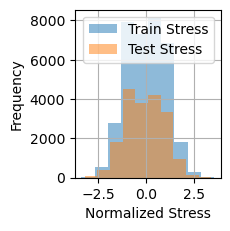

In [11]:
# Visualize a hisogram of the normalized data
plt.figure(1)
for i in range(1):
    plt.subplot(2,3,i+1)
    plt.hist(train_stress_encode[:,:,i].flatten().numpy(), bins=10, alpha=0.5, label='Train Stress')
    plt.hist(test_stress_encode[:,:,i].flatten().numpy(), bins=10, alpha=0.5, label='Test Stress')
    plt.legend()
    plt.grid()
    plt.xlabel('Normalized Stress')
    plt.ylabel('Frequency')
    plt.savefig("task_c_hist_norm.png")


In [12]:
ndim = strain.shape[2]  # Number of components
nstep = strain.shape[1] # Number of time steps
dt = 1/(nstep-1)        # Time step size
ndim, nstep, dt

(1, 50, 0.02040816326530612)

In [13]:
# Create data loader

train_set = Data.TensorDataset(train_strain_encode, train_stress)
test_set = Data.TensorDataset(test_strain_encode, test_stress)
train_loader = Data.DataLoader(train_set, batch_size, shuffle=True)
test_loader = Data.DataLoader(test_set, batch_size, shuffle=False)

In [51]:
############################# Define and train network #############################
# Create Neural network, define loss function and optimizer
"""
class Const_Net(nn.Module):
    def __init__(self):
        super(Const_Net, self).__init__()
        self.fc1 = nn.Linear(ndim*nstep, 3000)
        self.fc2 = nn.Linear(3000, 1000)
        self.fc3 = nn.Linear(1000, 300)
        self.fc4 = nn.Linear(300, ndim*nstep)
        
        self.batchnorm1 = nn.BatchNorm1d(3000)
        self.batchnorm2 = nn.BatchNorm1d(1000)
        self.batchnorm3 = nn.BatchNorm1d(300)
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = torch.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.fc3(x)
        x = self.batchnorm3(x)
        x = self.fc4(x)
        x = x.unflatten(1, (nstep, ndim))
        return x
"""
from models import LSTMStressPredictor
#net = Const_Net()
#net = Conv1DSeq2SeqStressPredictor(input_dim=ndim, output_dim=ndim, dropout=0.,num_blocks=8, kernel_size=11, hidden_dim=50)
#net = Const_Net()   # specify your neural network architecture
net =LSTMStressPredictor(
    input_dim=ndim, output_dim=ndim, 
    hidden_dim=100,#1000, 
    num_layers=2, #2
    dropout=0.1,
    bidirectional=True
)
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad) #Calculate the number of training parameters
print('Number of parameters: %d' % n_params)

Number of parameters: 364401


In [52]:
loss_func = Lossfunc() #define loss function
optimizer = torch.optim.Adam(net.parameters(), lr=lr) #define optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,gamma=gamma) #define learning rate scheduler


In [53]:
# Train network
loss_train_list = []
loss_test_list = []

In [54]:
print("Start training for {} epochs...".format(epochs))
for epoch in range(epochs):
    net.train(True)
    train_loss = 0.
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        input, target = data
        #define forward neural network evaluation below
        output_encode = net(input)
        output = stress_normalizer.denormalize(output_encode)
        
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
    
    # Compute your test loss below
    net.eval()
    test_loss = 0.
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            input, target = data
            output_encode = net(input)
            output = stress_normalizer.denormalize(output_encode)
            loss = loss_func(output, target)
            test_loss += loss.item()
            
    train_loss = round(train_loss/len(train_loader),5)
    test_loss = round(test_loss/len(test_loader),5)
    # Print train loss every 10 epochs
    if (epoch % 10 == 0):
        print("epoch:{}, train loss:{}, test loss:{}".format(epoch, train_loss, test_loss))
        
    # Save loss values for plotting
    loss_train_list.append(train_loss)
    loss_test_list.append(test_loss)

print("Final Train loss:{}".format(loss_train_list[-1]))
print("Final Test loss:{}".format(loss_test_list[-1]))
torch.save(net.state_dict(), 'task_c_lstm_model.pth')

Start training for 100 epochs...
epoch:0, train loss:2.61413, test loss:1.39922
epoch:10, train loss:0.20671, test loss:0.17294
epoch:20, train loss:0.17758, test loss:0.14957
epoch:30, train loss:0.17371, test loss:0.14729
epoch:40, train loss:0.1746, test loss:0.14704
epoch:50, train loss:0.17471, test loss:0.14702
epoch:60, train loss:0.17572, test loss:0.14702
epoch:70, train loss:0.17531, test loss:0.14702
epoch:80, train loss:0.17627, test loss:0.14702
epoch:90, train loss:0.17667, test loss:0.14702
Final Train loss:0.17502
Final Test loss:0.14702


In [55]:
from numpy import save as np_save 
#loss_train_list= loss_train_list[:40]
#loss_test_list= loss_test_list[:40]
np_save('task_c_lstm_loss_train.npy', loss_train_list)

np_save('task_c_lstm_loss_test.npy', loss_test_list)

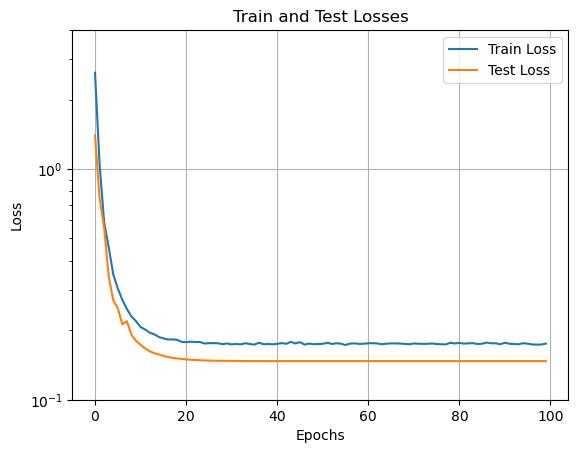

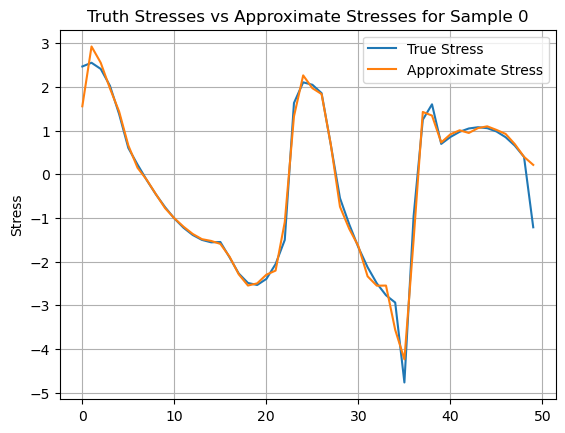

In [57]:
############################# Plot your result below using Matplotlib #############################
plt.figure(1)
plt.plot(loss_train_list, label='Train Loss')
plt.plot(loss_test_list, label='Test Loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.semilogy()
plt.ylim(0.1, 4)
plt.title('Train and Test Losses')
plt.savefig("task_c_lstm_loss_pp.png")


plt.figure(2)
plt.title('Truth Stresses vs Approximate Stresses for Sample {}'.format(0))
strain_encode, stress = test_set[0]
output_encode = net(strain_encode.unsqueeze(0))[0]
output = stress_normalizer.denormalize(output_encode)
target = stress
for i in range(ndim):
    plt.plot(target[:,i].detach().numpy(), label='True Stress')
    plt.plot(output[:,i].detach().numpy(), label='Approximate Stress')
    plt.grid()
    if i > 2:
        plt.xlabel('Time')
    if i%3==0:
        plt.ylabel('Stress')
    if i==ndim-1:
        plt.legend()
plt.savefig("task_c_samples_0.png")

# Try fitting epsilon(sigma) instead

In [20]:
net_inv = LSTMStressPredictor(input_dim=ndim, output_dim=ndim, hidden_dim=1000, num_layers=2, dropout=0.1)
n_params = sum(p.numel() for p in net_inv.parameters() if p.requires_grad) #Calculate the number of training parameters

In [21]:
train_set_inv = Data.TensorDataset(train_strain, train_stress_encode)
test_set_inv = Data.TensorDataset(test_strain, test_stress_encode)
train_loader_inv = Data.DataLoader(train_set, batch_size, shuffle=True)
test_loader_inv = Data.DataLoader(test_set, batch_size, shuffle=False)


In [22]:
print("Start training for {} epochs...".format(epochs))
loss_test_list_inv = []
loss_train_list_inv = []
for epoch in range(epochs):
    net_inv.train(True)
    train_loss = 0.
    for i, data in enumerate(train_loader_inv):
        optimizer.zero_grad()
        target, input = data
        #define forward neural network evaluation below
        output_encode = net_inv(input)
        output = strain_normalizer.denormalize(output_encode)
        
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
    
    # Compute your test loss below
    net_inv.eval()
    test_loss = 0.
    with torch.no_grad():
        for i, data in enumerate(test_loader_inv):
            target, input = data
            output_encode = net_inv(input)
            output = strain_normalizer.denormalize(output_encode)
            loss = loss_func(output, target)
            test_loss += loss.item()
            
    train_loss = round(train_loss/len(train_loader),5)
    test_loss = round(test_loss/len(test_loader),5)
    # Print train loss every 10 epochs
    if (epoch % 5 == 0):
        print("epoch:{}, train loss:{}, test loss:{}".format(epoch, train_loss, test_loss))
        
    # Save loss values for plotting
    loss_train_list_inv.append(train_loss)
    loss_test_list_inv.append(test_loss)

print("Final Train loss:{}".format(loss_train_list_inv[-1]))
print("Final Test loss:{}".format(loss_test_list_inv[-1]))

Start training for 40 epochs...
epoch:0, train loss:0.98968, test loss:1.12521


KeyboardInterrupt: 

In [228]:
del net_inv, train_set_inv, test_set_inv, train_loader_inv, test_loader_inv